In [1]:
import cv2, os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from sklearn.metrics import classification_report
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
import shutil
from scores import score_in_details
from torchensemble.utils import io
from torchensemble.gradient_boosting import GradientBoostingClassifier
torch.manual_seed(79)

ModuleNotFoundError: No module named 'torchensemble'

In [2]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size = (224, 224)),
        transforms.ToTensor(),
        ])

In [3]:
class MyDataset(Dataset):
    def __init__(self, ds, transform):
        self.ds = ds
        self.transform = transform
                
    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):            
        image_path = self.ds[idx][0]
        label = self.ds[idx][1]
        img = cv2.imread(image_path)
        img = self.transform(img)
            
        return {"image": img,
                "labels": label,
                "path": image_path}

In [4]:
dataset_path = "../dataset/Dataset_BUSI_with_GT/Normal/Splitted/test"
test_dataset = dsets.ImageFolder(root=f'{dataset_path}')
test_ds = MyDataset(ds=test_dataset.imgs, transform=transform)

In [5]:
test_loader = DataLoader(test_ds, batch_size=10, drop_last=True, shuffle=False)

In [6]:
class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()
        self.model = torchvision.models.densenet121(weights='DenseNet121_Weights.IMAGENET1K_V1')
        self.model.classifier = nn.Linear(in_features=1024, out_features=3, bias=True)
    
    def forward(self, data):
        return self.model(data)    

In [7]:
model = GradientBoostingClassifier(
    estimator=DenseNet,
    n_estimators=2,
    cuda=False)

In [8]:
model_path="../trained_model_new/gradient_boosting_normal_5_estimators_densenet/densenet_ensemble_model"

In [9]:
io.load(model, model_path)

In [10]:
def get_predictions():
    softmax = nn.Softmax(dim=1)
    model.eval()
    predictions = []
    real_values = []
    pred_probas = []
    misclassified = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            inputs = batch['image']
            labels = batch['labels']
            path = batch["path"]
            
            outputs = softmax(model(inputs))
            
            _, preds = torch.max(outputs, dim = 1)
            for probs in outputs.cpu():   
                pred_probas.append(list(probs.numpy()))
                
            preds = preds.cpu()
            labels = labels.cpu()
            predictions.extend(preds)
            real_values.extend(labels)
            
            for ind, (actual, pred) in enumerate(zip(labels, preds)):
                if actual != pred:
                    misclassified.append((path[ind], actual, pred))
            
    return predictions, real_values, pred_probas, misclassified

In [11]:
pred, real, probas, misclassified = get_predictions()
classes = ["BENIGN", "MALIGNANT", "NORMAL"]
print(classification_report(real, pred, digits=6, target_names=classes))

  0%|          | 0/73 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      BENIGN   0.975369  0.968215  0.971779       409
   MALIGNANT   0.950000  0.964467  0.957179       197
      NORMAL   0.975806  0.975806  0.975806       124

    accuracy                       0.968493       730
   macro avg   0.967059  0.969496  0.968255       730
weighted avg   0.968597  0.968493  0.968523       730



Accuracy: 96.9496205204417%
Precision: 0.9670586365803274
Recall: 0.9694962052044169
F1-score: 0.9682548113423405
MCC-score: 0.9462271671911414
ROC AUC score: 0.9957326020755476




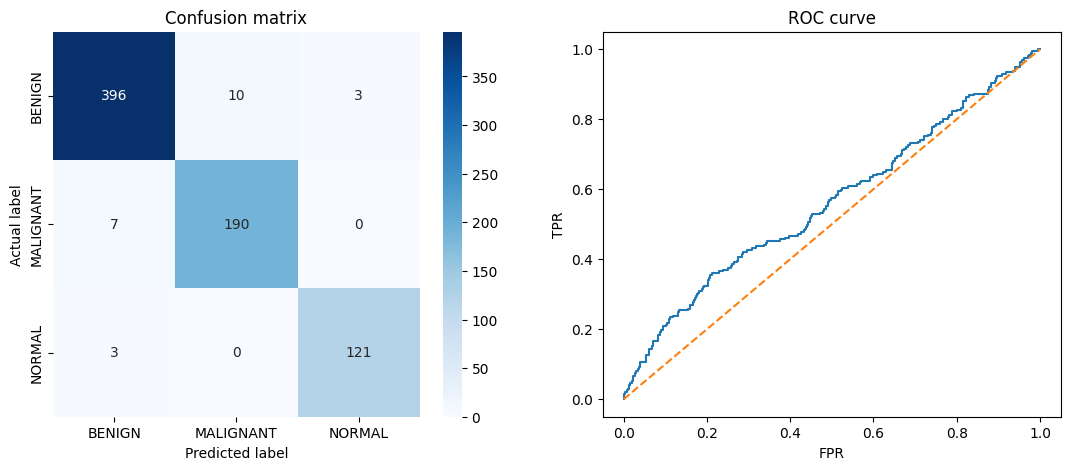

In [12]:
score_in_details(pred=pred, real=real, probas=probas, class_names=classes)

In [13]:
dest = "../misclassified-new/gradient-boosting-normal-densenet"
cnt = 1
for path, actual, pred in tqdm(misclassified):
    img_name = path.split("\\")[-1].split(".")[0]
    ext = path.split(".")[-1]
    shutil.copy(path, os.path.join(dest, f"{cnt}_{img_name}_{actual.item()}_{pred.item()}.{ext}"))
    cnt += 1

  0%|          | 0/23 [00:00<?, ?it/s]